In [10]:
import networkx as nx
import math
import osmnx as ox

def bpr_time(ff_time, flow, capacity, alpha=0.15, beta=4.0):
    """
    Bureau of Public Roads (BPR) volume-delay function.
    ff_time : free-flow time (hours)
    flow    : current link flow (vehicles/hour)
    capacity: link capacity (vehicles/hour)
    alpha, beta: BPR parameters
    Returns congested travel time on this link (hours).
    """
    if capacity <= 0:
        # Avoid division by zero
        return ff_time
    return ff_time * (1.0 + alpha * (flow / capacity)**beta)


def user_equilibrium_assignment(
    G, 
    OD, 
    max_iter=50, 
    tol=1e-3, 
    alpha=0.15, 
    beta=4.0, 
    cpus=1
):
    """
    Performs a User Equilibrium (UE) assignment using Method of Successive Averages (MSA).
    Uses OSMnx's ox.shortest_path function to process a list of OD pairs in each iteration.

    Parameters
    ----------
    G : networkx.MultiDiGraph
        The road network graph. Each edge should have:
           - 'ff_time': free-flow travel time (hours)
           - 'capacity': capacity (veh/hour)
           - 'flow': will be updated with assigned flows
    OD : dict
        OD[(o_node, d_node)] = demand (vehicles/hour or total vehicles),
        where o_node, d_node are valid node IDs in G.
    max_iter : int
        Maximum number of MSA iterations.
    tol : float
        Convergence threshold on total flow change.
    alpha, beta : float
        BPR function parameters.
    cpus : int
        Number of CPU cores to use for parallel shortest-path computations.

    Returns
    -------
    G : networkx.MultiDiGraph
        The same graph with updated 'flow' attributes for each edge after convergence or reaching max_iter.
    """
        
    # 1. Initialize flows on each edge to zero
    for u, v, k, data in G.edges(data=True, keys=True):
        data['flow'] = 0.0

    # We'll do up to max_iter iterations
    for iteration in range(1, max_iter+1):
        print(f"MSA Iteration {iteration}...")

        # 2. Recompute travel times using the BPR function
        for u, v, k, data in G.edges(data=True, keys=True):
            ff_time = data.get('ff_time', 0.0)
            old_flow = data.get('flow', 0.0)
            cap = data.get('capacity', 9999999.0)
            data['time'] = bpr_time(ff_time, old_flow, cap, alpha=alpha, beta=beta)

        print("Initialized")
        
        # 3. Create a structure to accumulate "temp_flow" for this iteration's all-or-nothing assignment
        temp_flow = {(u, v, k): 0.0 for u, v, k in G.edges(keys=True)}

        # 4. Build arrays of origins, destinations (for OSMnx batch shortest_path)
        #    plus an index that maps back so we know which OD pair each path corresponds to
        od_pairs = list(OD.keys())  # [(o1, d1), (o2, d2), ...]
        origins = [od[0] for od in od_pairs]
        destinations = [od[1] for od in od_pairs]

        # 5. Run OSMnx batch shortest paths in parallel (if cpus>1)
        #    This returns a list of paths, each path is a list of node IDs
        try:
            paths = ox.shortest_path(
                G,
                orig=origins,
                dest=destinations,
                weight='time',
                cpus=cpus
            )
        except :
            # If no path is found for some pair(s), handle it gracefully below
            print(f"Path not found in graph: {origins} or {destinations}")
            paths = [None]*len(origins)

        print("Got paths")

        # 6. Accumulate flows on each edge according to the all-or-nothing assignment
        for i, path in enumerate(paths):
            if path is None:
                # No path found for this OD pair
                continue
            (o, d) = od_pairs[i]
            demand = OD[(o, d)]
            if demand <= 0:
                continue

            # Walk through the path's edges
            for idx in range(len(path) - 1):
                u = path[idx]
                v = path[idx+1]
                # handle potential multi-edge scenario
                if not G.has_edge(u, v, 0):
                    possible_keys = list(G[u][v].keys())
                    edge_key = (u, v, possible_keys[0])
                else:
                    edge_key = (u, v, 0)
                temp_flow[edge_key] += demand

        print("Accumulated flows")
        
        # 7. MSA flow update
        alpha_k = 1.0 / iteration  # step size
        flow_change = 0.0
        for (u, v, k, data) in G.edges(data=True, keys=True):
            oldF = data['flow']
            newF = oldF + alpha_k * (temp_flow[(u, v, k)] - oldF)
            flow_change += abs(newF - oldF)
            data['flow'] = newF

        # 8. Convergence Check
        if flow_change < tol:
            print(f"Converged at iteration {iteration} (flow_change={flow_change:.6f} < {tol})")
            break

    print("Assignment complete.")
    return G

In [2]:
import os
import osmnx as ox

# Example: create a bounding box or place name
place_name = "Hamilton County, TN, USA"

G = ox.graph_from_place(place_name, network_type='drive_service')
# Convert to geodataframes
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

os.makedirs('osmx_files/', exist_ok=True)
# Convert any columns that contain lists to strings to avoid errors when writing shapefile
for col in edges.columns:
	if edges[col].apply(lambda x: isinstance(x, list)).any():
		edges[col] = edges[col].astype(str)
edges.to_file("osmx_files/county_edges.shp")

In [11]:
import math

for u, v, key, data in G.edges(keys=True, data=True):
    # data['length'] is in meters
    # data.get('maxspeed') might be missing, so let's approximate
    highway_type = data.get('highway', None)
    
    if highway_type in ['motorway', 'motorway_link']:
        data['capacity'] = 2000  # vehicles/hour/lane (example)
        data['ff_speed'] = 100  # km/h
    elif highway_type in ['primary', 'secondary']:
        data['capacity'] = 1500
        data['ff_speed'] = 80
    else:
        data['capacity'] = 800
        data['ff_speed'] = 40

    # Compute free-flow travel time in hours:
    length_km = data['length'] / 1000.0
    data['ff_time'] = length_km / data['ff_speed']  # hours


In [12]:
import pandas as pd

od_path = './move_od/lodes_0.csv'
input_od = pd.read_csv(od_path)
node_ids = list(G.nodes())

In [13]:
from joblib import Parallel, delayed
import osmnx as ox

# Function to find nearest nodes
def find_nearest_nodes(o_lon, o_lat, d_lon, d_lat):
    o_node = ox.distance.nearest_nodes(G, o_lon, o_lat)
    d_node = ox.distance.nearest_nodes(G, d_lon, d_lat)
    return o_node, d_node

# Extract relevant rows
drive_trips = input_od[input_od["mode_type"] == "drive"]

# Extract lat-lon
o_lat = drive_trips["origin_loc_lat"].values
o_lon = drive_trips["origin_loc_lon"].values
d_lat = drive_trips["dest_loc_lat"].values
d_lon = drive_trips["dest_loc_lon"].values

# Parallel processing
o_nodes = ox.distance.nearest_nodes(G, o_lon, o_lat)
d_nodes = ox.distance.nearest_nodes(G, d_lon, d_lat)

print("Got nodes")

# Initialize OD dictionary
OD = {}

# Accumulate in OD dictionary
for o_node, d_node in zip(o_nodes, d_nodes):
    if (o_node, d_node) not in OD:
        OD[(o_node, d_node)] = 0
    OD[(o_node, d_node)] += 1  # Assuming each row is a single trip

Got nodes


In [19]:
cpus = os.cpu_count()
G_assigned = user_equilibrium_assignment(G, OD, max_iter=10, tol=1e-3, alpha=0.15, beta=4, cpus=int(cpus))

MSA Iteration 1...
Initialized
Got paths
Accumulated flows
MSA Iteration 2...
Initialized
Got paths
Accumulated flows
MSA Iteration 3...
Initialized
Got paths
Accumulated flows
MSA Iteration 4...
Initialized
Got paths
Accumulated flows
MSA Iteration 5...
Initialized
Got paths
Accumulated flows
MSA Iteration 6...
Initialized
Got paths
Accumulated flows
MSA Iteration 7...
Initialized
Got paths
Accumulated flows
MSA Iteration 8...
Initialized
Got paths
Accumulated flows
MSA Iteration 9...
Initialized
Got paths
Accumulated flows
MSA Iteration 10...
Initialized
Got paths
Accumulated flows
Assignment complete.


In [23]:
import osmnx as ox

# Suppose G_assigned is your final graph with edge flows, edge geometry, etc.
ox.save_graphml(G_assigned, filepath="osmnx_files/assigned_flows.graphml")

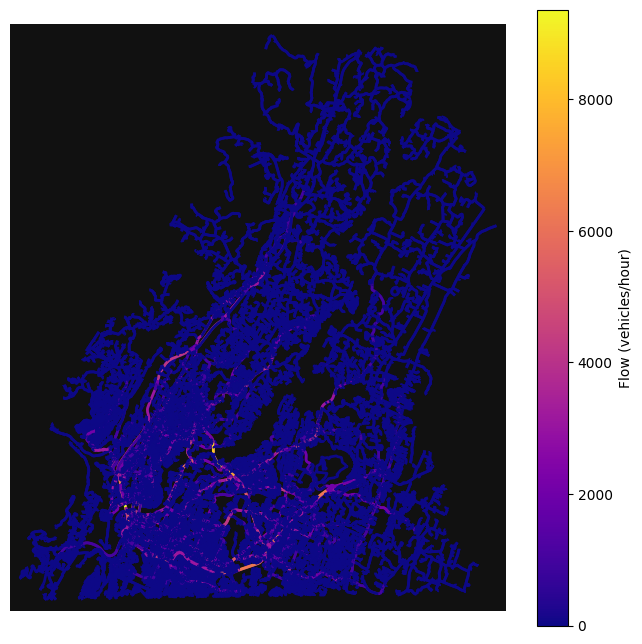

In [29]:
import matplotlib.pyplot as plt
import osmnx as ox
import matplotlib.colors as mcolors

# 1. Gather the flow values so we know the min/max
flow_values = [G_assigned[u][v][k]['flow'] for (u, v, k) in G_assigned.edges(keys=True)]
flow_min, flow_max = min(flow_values), max(flow_values)

# 2. Generate edge colors by flow
#    Here we use 'plasma' colormap with 10 bins
ec = ox.plot.get_edge_colors_by_attr(
    G=G_assigned,
    attr='flow',
    cmap='plasma',
    num_bins=10
)

# 3. Plot graph WITHOUT immediately showing/closing
fig, ax = ox.plot_graph(
    G=G_assigned,
    edge_color=ec,
    edge_linewidth=2,
    node_size=0,
    show=False,        # do not show yet
    close=False        # do not close figure so we can add a colorbar
)

# 4. Create a ScalarMappable that matches the color scale
#    This ensures the colorbar aligns with the min/max flows used above.
norm = mcolors.Normalize(vmin=flow_min, vmax=flow_max)
sm = plt.cm.ScalarMappable(norm=norm, cmap='plasma')
sm.set_array([])  # dummy array for colorbar

# 5. Add the colorbar (legend) to the figure
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Flow (vehicles/hour)")

# 6. Finally, display the updated figure with legend
plt.show()


In [27]:
import folium
import networkx as nx
import random

def plot_od_routes_folium(G, OD, start_zoom=12, weight='time'):
    """
    Create a Folium map showing each OD route on the final assigned graph G.

    Parameters
    ----------
    G : networkx.MultiDiGraph
        - Must contain node attributes 'x' (longitude) and 'y' (latitude).
        - Edges should have a 'time' (or your chosen weight) if you're routing by final congested travel time.
    OD : dict
        - A dictionary {(origin, destination): demand} with node IDs from G as keys.
    start_zoom : int
        - Initial zoom for Folium map.
    weight : str
        - Edge attribute to use as the cost for shortest-path (e.g. 'time', 'length', etc.).
    """

    # 1) Pick a central location for the map
    #    For example, use the average of all node lat/lons in G
    #    or pick a known central coordinate.
    #    Here we do a simple average of node coordinates:
    xs = [data['x'] for _, data in G.nodes(data=True)]
    ys = [data['y'] for _, data in G.nodes(data=True)]
    if len(xs) == 0 or len(ys) == 0:
        raise ValueError("No node coordinates found in G. Each node needs 'x' and 'y' attributes.")

    center_lon = sum(xs) / len(xs)
    center_lat = sum(ys) / len(ys)

    # 2) Create the Folium map
    m = folium.Map(location=[center_lat, center_lon], zoom_start=start_zoom)

    # 3) For each OD pair, compute route and draw it
    for (o, d), demand in OD.items():
        if demand <= 0:
            continue  # skip zero-demand or negative

        # Compute shortest path based on final edge costs (e.g., 'time')
        try:
            path_nodes = nx.shortest_path(G, source=o, target=d, weight=weight)
        except nx.NetworkXNoPath:
            # No route found
            continue

        # Build list of (latitude, longitude) for the route
        route_coords = []
        for node in path_nodes:
            lat = G.nodes[node]['y']
            lon = G.nodes[node]['x']
            route_coords.append((lat, lon))

        # 3.1 Add a PolyLine for this route
        #     Random color for each route if you want them distinguishable
        route_color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        folium.PolyLine(
            locations=route_coords,
            color=route_color,
            weight=4,  # line thickness
            opacity=0.8,
            tooltip=f"OD: {o}->{d}, Demand: {demand}"
        ).add_to(m)

        # 3.2 Add markers for origin and destination
        #     (Optional) you could place them only once if many OD pairs share nodes
        o_lat, o_lon = route_coords[0]
        d_lat, d_lon = route_coords[-1]

        folium.Marker(
            location=[o_lat, o_lon],
            popup=f"Origin: {o} (Demand: {demand})",
            icon=folium.Icon(color="green", icon="play")
        ).add_to(m)

        folium.Marker(
            location=[d_lat, d_lon],
            popup=f"Destination: {d}",
            icon=folium.Icon(color="red", icon="stop")
        ).add_to(m)

    return m  # returns the Folium map object

In [ ]:
map_folium.save("od_routes.html")

In [22]:
od_pairs = list(OD.keys())
origins = [t[0] for t in od_pairs]
destinations = [t[1] for t in od_pairs]

paths = ox.shortest_path(G_assigned, orig=origins, dest=destinations, weight='time', cpus=4)

# Then compute total time for each path
final_paths = {}
for i, path_nodes in enumerate(paths):
    (o, d) = od_pairs[i]
    demand = OD[(o, d)]
    if path_nodes is None or demand <= 0:
        continue
    
    total_time = 0.0
    for idx in range(len(path_nodes)-1):
        u = path_nodes[idx]
        v = path_nodes[idx+1]
        if not G_assigned.has_edge(u, v, 0):
            possible_keys = list(G_assigned[u][v].keys())
            edge_key = (u, v, possible_keys[0])
        else:
            edge_key = (u, v, 0)
        total_time += G_assigned[u][v][edge_key]['time']

    final_paths[(o, d)] = {
        "path": path_nodes,
        "travel_time": total_time,
        "demand": demand
    }
